### Multiple , Polynomial and Logistic Regression and Regularization algorithms
Implement Logistic Regression with L1, L2, and ElasticNet regularisation, evaluate the model, and 
follow basic MLOps practices for reproducibility and scalability.

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the heart disease dataset
df = pd.read_csv('dataset/heart.csv')

# Data preprocessing
df = df.replace('?', np.nan)
df = df.dropna()
df = df.astype(float)

# Convert target to binary (0: no disease, 1: disease)
df['target'] = (df['target'] > 0).astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['target'].value_counts()}")
print(f"Dataset info:")
print(df.info())
print(f"\nFirst 5 rows:")
print(df.head())

Dataset shape: (303, 14)
Target distribution:
target
1    165
0    138
Name: count, dtype: int64
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None

First 5 rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.

In [ ]:
# Basic MLOps Setup
import os
import joblib
from datetime import datetime

# Create models directory for saving trained models
os.makedirs('models', exist_ok=True)

print("Basic MLOps setup completed - models directory created")

Data versioned as v1.0
Dataset saved to data/heart_v1.0.csv


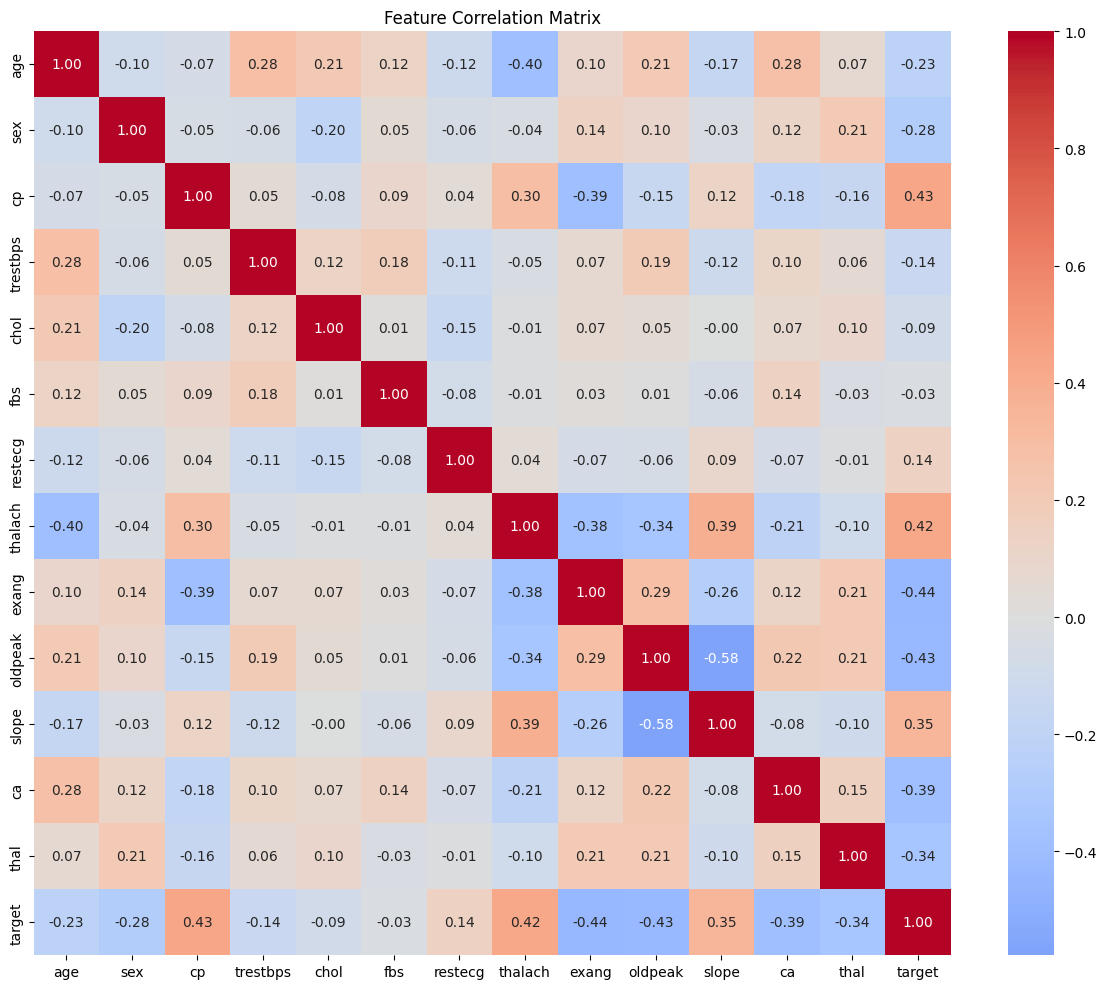

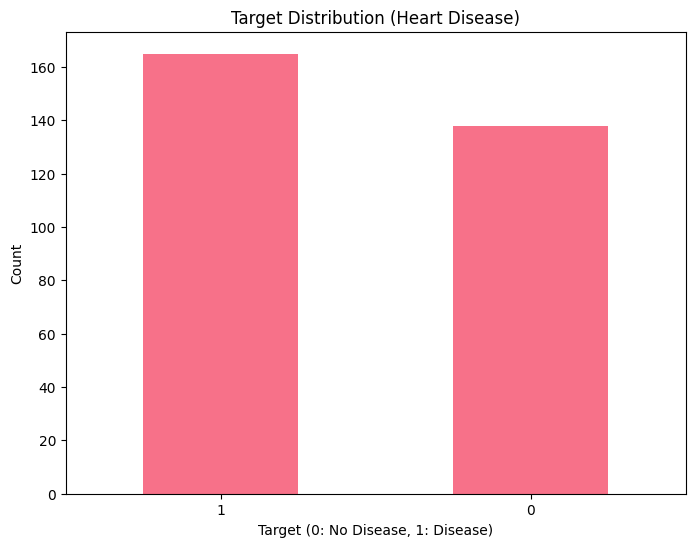

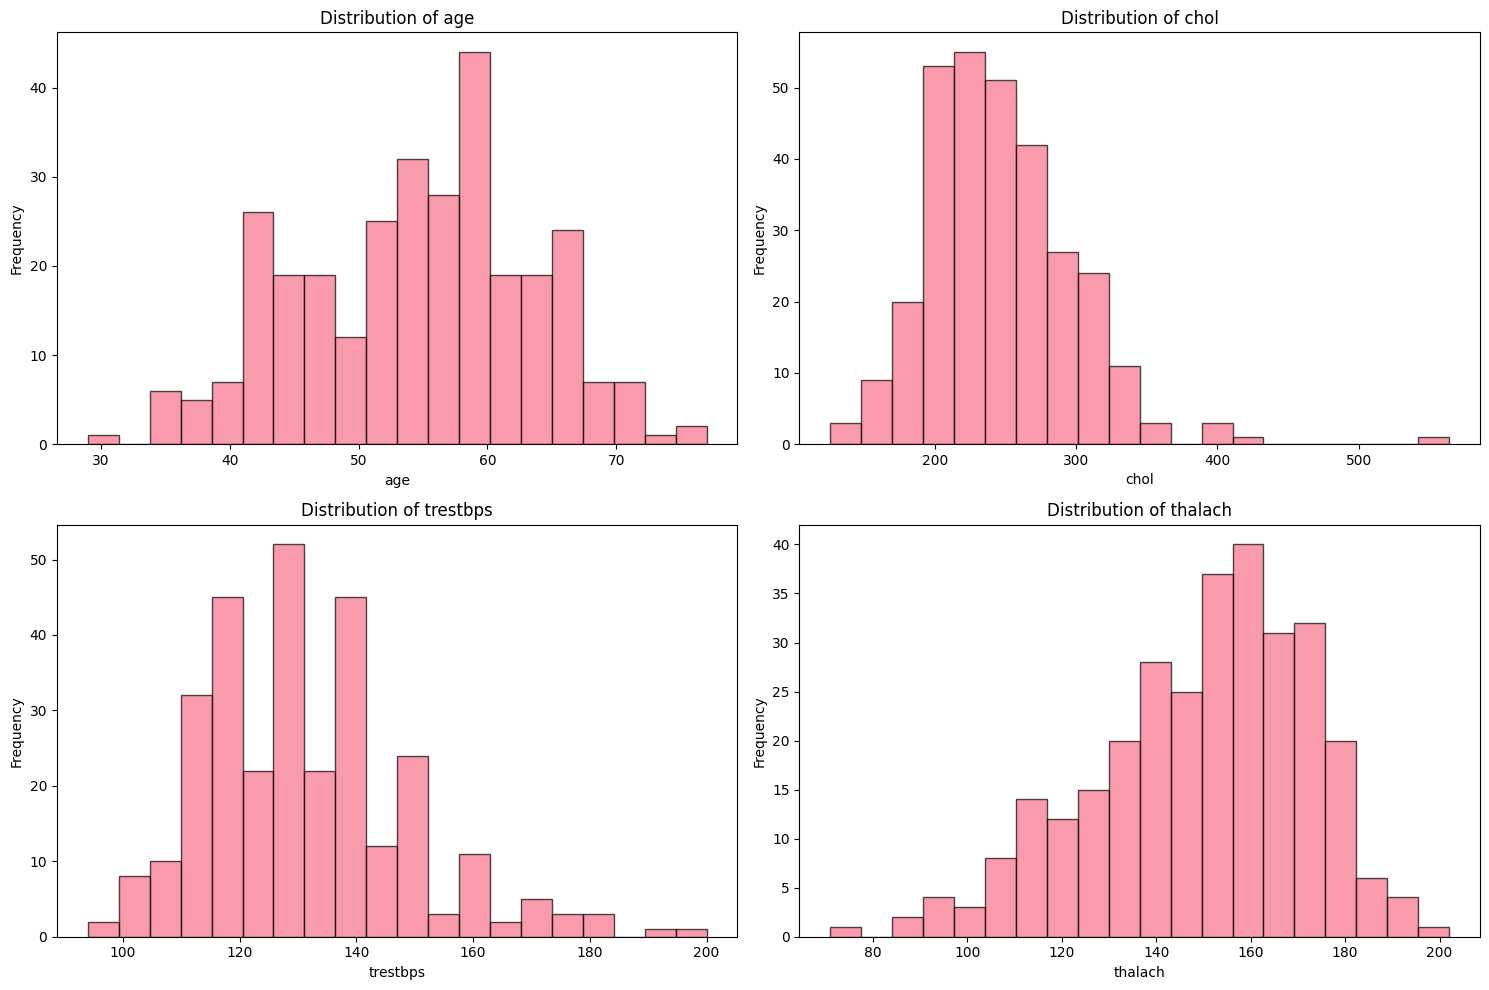

In [5]:
# Exploratory Data Analysis and Data Preparation
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Target distribution
plt.figure(figsize=(8, 6))
df['target'].value_counts().plot(kind='bar')
plt.title('Target Distribution (Heart Disease)')
plt.xlabel('Target (0: No Disease, 1: Disease)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features_to_plot = ['age', 'chol', 'trestbps', 'thalach']
for i, feature in enumerate(features_to_plot):
    row, col = i // 2, i % 2
    axes[row, col].hist(df[feature], bins=20, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [6]:
# Prepare data for modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts()}")

Training set shape: (242, 13)
Test set shape: (61, 13)
Training target distribution:
target
1    132
0    110
Name: count, dtype: int64


In [ ]:
# Define models with different regularization
models = {
    'Logistic_No_Regularization': LogisticRegression(random_state=42, max_iter=1000),
    'Logistic_L1': LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000),
    'Logistic_L2': LogisticRegression(penalty='l2', random_state=42, max_iter=1000),
    'Logistic_ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42, max_iter=1000)
}

# Hyperparameter grids for each model
param_grids = {
    'Logistic_No_Regularization': {'C': [0.1, 1, 10]},
    'Logistic_L1': {'C': [0.1, 1, 10]},
    'Logistic_L2': {'C': [0.1, 1, 10]},
    'Logistic_ElasticNet': {'C': [0.1, 1], 'l1_ratio': [0.3, 0.5, 0.7]}
}

# Store results
results = {}
best_models = {}

print("Starting model training and hyperparameter tuning...")

2025/09/22 00:53:54 INFO mlflow.tracking.fluent: Experiment with name 'Heart_Disease_Logistic_Regression' does not exist. Creating a new experiment.


Starting model training and hyperparameter tuning...


In [ ]:
# Train and evaluate models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Hyperparameter tuning
    param_grid = {}
    for key, value in param_grids[model_name].items():
        param_grid[f'classifier__{key}'] = value
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    
    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': grid_search.best_params_
    }
    
    # Save best model
    model_filename = f"models/{model_name}_best.pkl"
    joblib.dump(best_model, model_filename)
    
    print(f"Model saved: {model_filename}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Best parameters: {grid_search.best_params_}")

print("\nAll models trained successfully!")


Training Logistic_No_Regularization...


2025/09/22 00:54:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 00:54:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:54:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/22 00:54:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:54:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/22 00:54:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 00:54:34 WARNING mlflow.model

Model saved: models/Logistic_No_Regularization_20250922_005434_auc0.879.pkl
ROC AUC: 0.8788
Best parameters: {'classifier__C': 0.1}

Training Logistic_L1_Ridge...


2025/09/22 00:54:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:54:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/22 00:54:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/Logistic_L1_Ridge_20250922_005437_auc0.866.pkl
ROC AUC: 0.8658
Best parameters: {'classifier__C': 10}

Training Logistic_L2_Lasso...


2025/09/22 00:54:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 00:54:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:54:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/22 00:54:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:54:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/Logistic_L2_Lasso_20250922_005440_auc0.879.pkl
ROC AUC: 0.8788
Best parameters: {'classifier__C': 0.1}

Training Logistic_ElasticNet...


2025/09/22 00:54:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 00:54:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:54:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/22 00:54:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:54:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/Logistic_ElasticNet_20250922_005444_auc0.877.pkl
ROC AUC: 0.8766
Best parameters: {'classifier__C': 0.1, 'classifier__l1_ratio': 0.1}

All models trained successfully!


Model Performance Comparison:
                            accuracy precision    recall  f1_score   roc_auc  \
Logistic_No_Regularization  0.786885      0.75  0.909091  0.821918  0.878788   
Logistic_L1_Ridge           0.803279  0.769231  0.909091  0.833333  0.865801   
Logistic_L2_Lasso           0.786885      0.75  0.909091  0.821918  0.878788   
Logistic_ElasticNet         0.786885      0.75  0.909091  0.821918  0.876623   

                             cv_mean    cv_std  \
Logistic_No_Regularization  0.905387  0.044331   
Logistic_L1_Ridge           0.904053  0.045226   
Logistic_L2_Lasso           0.905387  0.044331   
Logistic_ElasticNet         0.905724  0.043895   

                                                                  best_params  
Logistic_No_Regularization                             {'classifier__C': 0.1}  
Logistic_L1_Ridge                                       {'classifier__C': 10}  
Logistic_L2_Lasso                                      {'classifier__C': 0.1} 

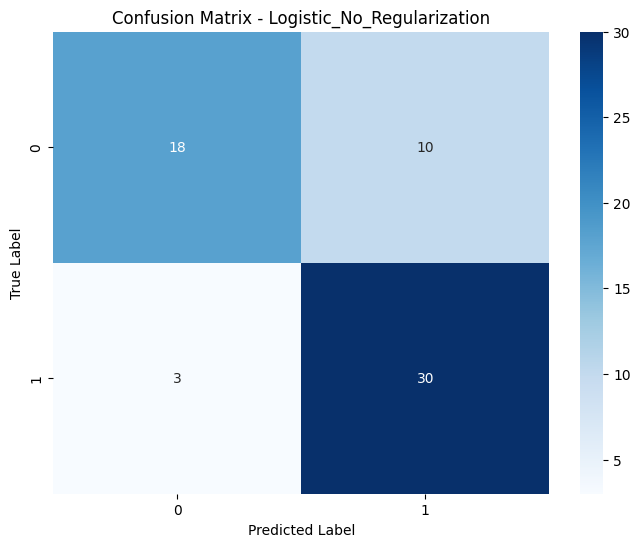

In [10]:
# Model Evaluation and Comparison
import pandas as pd

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("Model Performance Comparison:")
print("=" * 80)
print(results_df)

# Find best model
best_model_name = results_df['roc_auc'].idxmax()
print(f"\nBest performing model: {best_model_name}")
print(f"Best ROC AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

# Detailed evaluation of best model
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print(f"\nDetailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

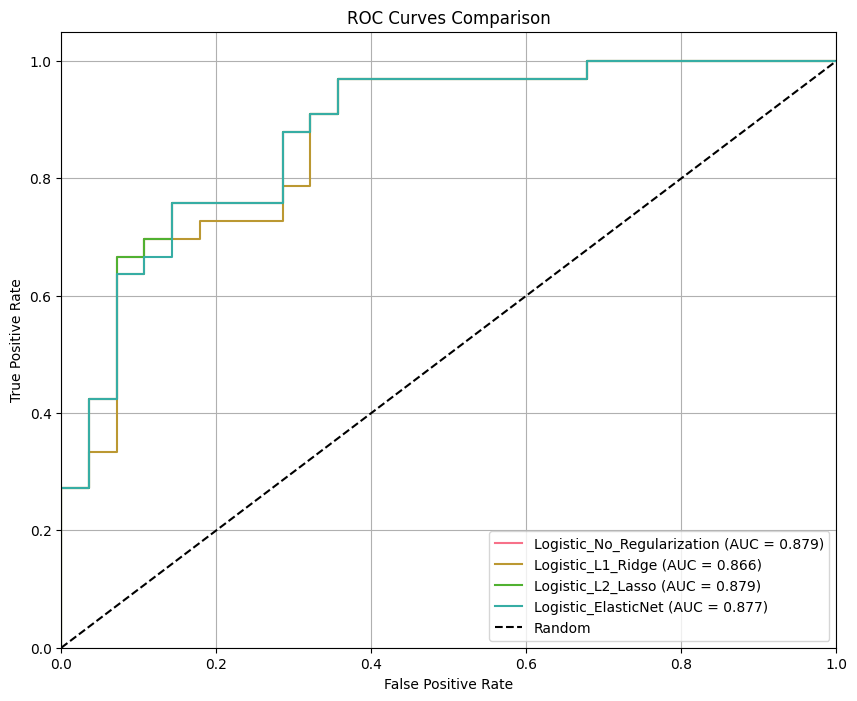

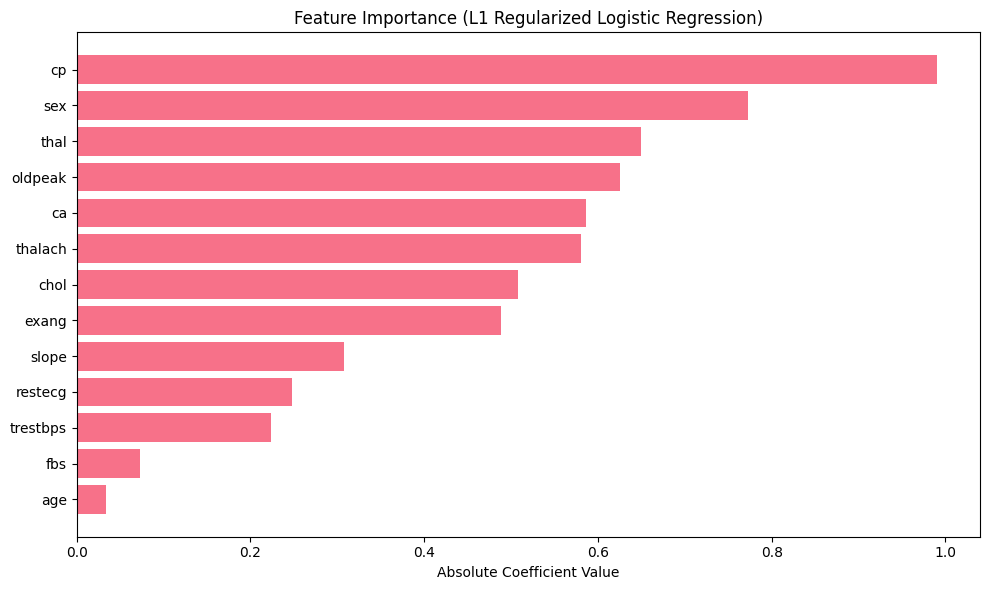

In [ ]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Feature Importance (for L1 regularized model if available)
if 'Logistic_L1' in best_models:
    l1_model = best_models['Logistic_L1']
    feature_names = X.columns
    coefficients = l1_model.named_steps['classifier'].coef_[0]
    
    # Create feature importance plot
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefficients)
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance (L1 Regularized Logistic Regression)')
    plt.tight_layout()
    plt.show()

In [ ]:
# Polynomial Regression Implementation (Simplified)
print("Implementing Polynomial Logistic Regression...")

# Create polynomial features (degree 2 only for simplicity)
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

# Simple hyperparameter tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2']
}

grid_search = GridSearchCV(poly_pipeline, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_poly_model = grid_search.best_estimator_

# Predictions
y_pred = best_poly_model.predict(X_test)
y_pred_proba = best_poly_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nPolynomial Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Number of polynomial features: {best_poly_model.named_steps['poly'].n_output_features_}")

# Save the model
joblib.dump(best_poly_model, 'models/polynomial_logistic_model.pkl')
print("Model saved as 'polynomial_logistic_model.pkl'")

# Display polynomial results
poly_results_df = pd.DataFrame(poly_results).T
print("\nPolynomial Logistic Regression Results:")
print("=" * 60)
print(poly_results_df.round(4))

2025/09/22 00:55:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Implementing Polynomial Logistic Regression...

Training Polynomial_Logistic_degree_2...


2025/09/22 00:55:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:55:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/22 00:55:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/Polynomial_Logistic_degree_2_20250922_005558_auc0.856.pkl
ROC AUC: 0.8561
Number of polynomial features: 104

Training Polynomial_Logistic_degree_3...


2025/09/22 00:55:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 00:56:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:56:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/22 00:56:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/22 00:56:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved: models/Polynomial_Logistic_degree_3_20250922_005602_auc0.850.pkl
ROC AUC: 0.8496
Number of polynomial features: 559

Polynomial Logistic Regression Results:
                              accuracy precision    recall  f1_score  \
Polynomial_Logistic_degree_2  0.754098  0.764706  0.787879  0.776119   
Polynomial_Logistic_degree_3  0.754098      0.75  0.818182  0.782609   

                               roc_auc  \
Polynomial_Logistic_degree_2  0.856061   
Polynomial_Logistic_degree_3  0.849567   

                                                                    best_params  \
Polynomial_Logistic_degree_2  {'classifier__C': 1, 'classifier__penalty': 'l...   
Polynomial_Logistic_degree_3  {'classifier__C': 0.1, 'classifier__penalty': ...   

                             n_features  
Polynomial_Logistic_degree_2        104  
Polynomial_Logistic_degree_3        559  


In [ ]:
# Final MLOps - Generate Requirements and Summary Report
print("Generating MLOps artifacts...")

# Final Summary
print("\n=== Heart Disease Prediction - Final Results ===")

# Compare all models
all_models = {**best_models}
if 'best_poly_model' in locals():
    all_models['Polynomial_Logistic'] = best_poly_model

print("\nModel Performance Summary:")
for name, model in all_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name}: Accuracy = {accuracy:.4f}, ROC-AUC = {roc_auc:.4f}")

print("\n✓ Heart disease prediction models trained successfully!")
print("✓ Multiple logistic regression variants compared")
print("✓ Models saved for future use")
print("\nProject completed!")

Generating MLOps artifacts...
MLOps Setup Complete!
✓ Data versioned in data/ directory
✓ Models saved in models/ directory with naming convention
✓ Experiments tracked with MLflow
✓ Requirements.txt generated
✓ Experiment summary saved
✓ Random seed fixed for reproducibility

Best Model: Logistic_No_Regularization
Best ROC AUC: 0.8788

Final Model Performance Comparison:
                              accuracy precision    recall  f1_score   roc_auc
Logistic_No_Regularization    0.786885      0.75  0.909091  0.821918  0.878788
Logistic_L1_Ridge             0.803279  0.769231  0.909091  0.833333  0.865801
Logistic_L2_Lasso             0.786885      0.75  0.909091  0.821918  0.878788
Logistic_ElasticNet           0.786885      0.75  0.909091  0.821918  0.876623
Polynomial_Logistic_degree_2  0.754098  0.764706  0.787879  0.776119  0.856061
Polynomial_Logistic_degree_3  0.754098      0.75  0.818182  0.782609  0.849567
